In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import utils as nn_utils
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
def generate_line(n, sign = "+"):
    t = torch.linspace(-3, 3, n)
    x = t.view(-1, 1)
    if sign == "+":
        y = t.view(-1, 1)
    else:
        y = -t.view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)


def generate_line_small(n, sign = "+"):
    t = torch.linspace(-1, 1, n)
    x = t.view(-1, 1)
    if sign == "+":
        y = t.view(-1, 1)
    else:
        y = -t.view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)

def generate_parabola(n, sign = "+"):
    t = torch.linspace(-10, 10, n)
    x = (t).view(-1, 1)
    if sign == "+":
        y =((t**2).view(-1, 1) + 5)/5
    else:
        y = (-(t**2).view(-1, 1) - 5)/5
    return torch.cat((x, y), dim=1).unsqueeze(0)

def generate_circle(n, r = 1):
    t = torch.linspace(0, 2 * torch.pi - 1e-3, n)
    x = (r * torch.cos(t)).view(-1, 1)
    y = (r * torch.sin(t)).view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)


def generate_sphere(n, a = 1, b = 1, c = 1):
    t1 = torch.linspace(0, 2*torch.pi - 1e-3, n)
    t2 = torch.linspace(0, torch.pi - 1e-3, n)
    grid_t1, grid_t2 = torch.meshgrid((t1, t2), indexing='ij')
    # t = torch.stack((grid_t1, grid_t2), dim=-1).reshape(-1, 2).to(device)
    x = (a * torch.sin(grid_t1) * torch.cos(grid_t2)).view(-1, 1)
    y = (b * torch.sin(grid_t1) *  torch.sin(grid_t2)).view(-1, 1)
    z = (c * torch.cos(grid_t1)).view(-1, 1)
    return torch.cat((x, y, z), dim=1).unsqueeze(0)

def generate_donut(n, a = 1, b = 1, c = 1):
    t1 = torch.linspace(0, 2*torch.pi - 1e-3, n)
    t2 = torch.linspace(0, 2*torch.pi - 1e-3, n)
    grid_t1, grid_t2 = torch.meshgrid((t1, t2), indexing='ij')
    # t = torch.stack((grid_t1, grid_t2), dim=-1).reshape(-1, 2).to(device)
    x = ((torch.sin(grid_t1) + 2) * torch.cos(grid_t2)).view(-1, 1)
    y = ((torch.sin(grid_t1) + 2) *  torch.sin(grid_t2)).view(-1, 1)
    z = 0.5*(torch.cos(grid_t1)).view(-1, 1)
    return torch.cat((x, y, z), dim=1).unsqueeze(0)

def generate_3D_ellipse(n, r1 = 1, r2 = 0.5):
    t = torch.linspace(0, 2 * torch.pi, n+1)
    x = (r1 * torch.cos(t)).view(-1, 1)[:-1]
    y = (r2 * torch.sin(t)).view(-1, 1)[:-1]
    z = (0 * torch.sin(t)).view(-1, 1)[:-1]
    return torch.cat((x, y, z), dim=1).unsqueeze(0)


def generate_ellipse(n, r1 = 1, r2 = 0.5):
    t = torch.linspace(0, 2*torch.pi - 1e-3, n+1)
    x = (r1 * torch.cos(t)).view(-1, 1)[:-1]
    y = (r2 * torch.sin(t)).view(-1, 1)[:-1]
    return torch.cat((x, y), dim=1).unsqueeze(0)

def generate_cube(n, a):
    n = n**2
    R = int(round(math.sqrt(n / 6.0)))
    R = max(R, 1)  # ensure at least 1

    half = a / 2
    coords = torch.linspace(-half, half, R)  # shape: (R,)

    Y, Z = torch.meshgrid(coords, coords, indexing='ij')  # (R, R)
    face_x_min = torch.stack([
        torch.full_like(Y, -half),  # x = -half
        Y,
        Z
    ], dim=-1).reshape(-1, 3)  # (R*R, 3)
    face_x_max = torch.stack([
        torch.full_like(Y, half),   # x = +half
        Y,
        Z
    ], dim=-1).reshape(-1, 3)

    # Face y = -half and y = +half (vary x, z)
    X, Z = torch.meshgrid(coords, coords, indexing='ij')
    face_y_min = torch.stack([
        X,
        torch.full_like(X, -half),  # y = -half
        Z
    ], dim=-1).reshape(-1, 3)
    face_y_max = torch.stack([
        X,
        torch.full_like(X, half),   # y = +half
        Z
    ], dim=-1).reshape(-1, 3)

    # Face z = -half and z = +half (vary x, y)
    X, Y = torch.meshgrid(coords, coords, indexing='ij')
    face_z_min = torch.stack([
        X,
        Y,
        torch.full_like(X, -half)   # z = -half
    ], dim=-1).reshape(-1, 3)
    face_z_max = torch.stack([
        X,
        Y,
        torch.full_like(X, half)    # z = +half
    ], dim=-1).reshape(-1, 3)

    # Concatenate all faces
    faces = torch.cat([
        face_x_min, face_x_max,
        face_y_min, face_y_max,
        face_z_min, face_z_max
    ], dim=0)  # shape: (6*R^2, 3)

    # Add batch dimension
    return faces.unsqueeze(0)
    
def square_edges(a, n):
    if n % 4 != 0:
        raise ValueError("n must be divisible by 4 to evenly distribute points across all edges.")

    # Number of points per edge
    points_per_edge = n // 4
    half_a = a / 2

    # Bottom edge: from (-a/2, -a/2) to (a/2, -a/2)
    bottom_edge = torch.stack([
        torch.linspace(-half_a+1, half_a, points_per_edge),      # x-coordinates
        torch.full((points_per_edge,), -half_a)                # y-coordinates
    ], dim=-1)

    # Right edge: from (a/2, -a/2) to (a/2, a/2)
    right_edge = torch.stack([
        torch.full((points_per_edge,), half_a),                # x-coordinates
        torch.linspace(-half_a, half_a, points_per_edge)       # y-coordinates
    ], dim=-1)

    # Top edge: from (a/2, a/2) to (-a/2, a/2)
    top_edge = torch.stack([
        torch.linspace(half_a, -half_a, points_per_edge),      # x-coordinates
        torch.full((points_per_edge,), half_a)                 # y-coordinates
    ], dim=-1)

    # Left edge: from (-a/2, a/2) to (-a/2, -a/2)
    left_edge = torch.stack([
        torch.full((points_per_edge,), -half_a),               # x-coordinates
        torch.linspace(half_a, -half_a, points_per_edge)       # y-coordinates
    ], dim=-1)

    # Concatenate all edges in the desired order:
    # Bottom edge, Right edge, Top edge, Left edge
    square = torch.cat([bottom_edge, right_edge, top_edge, left_edge], dim=0)

    # Add batch dimension (1, n, 2)
    square = square.unsqueeze(0)

    return square

def generate_data(n, sign = "+"):
    line = generate_line(n, sign)
    line2 = generate_line(n, sign = '-')
    parabola = generate_parabola(n, sign)
    parabola1 = generate_parabola(n, sign = '-')
    circle = generate_circle(n)
    circle1 = generate_circle(n, r=2)
    e1 = generate_ellipse(n, r1 = 1.5, r2 = 3)
    e2 = generate_ellipse(n, r1 = 3, r2 = 1.5)
    e4 =  generate_ellipse(n, r1 = 5, r2 = 5)
    e5 = square_edges(a = 10, n = n)
    e3 = generate_ellipse(n, r1 = 2.5, r2 = 2.5)
    curves = torch.concat((e5, e4))
    #curves = torch.concat((curves, e3))

    # start_x = -3.0
    # end_x = 3.0
    # x_coords = torch.linspace(start_x, end_x, steps=40)

    # # The y-coordinate is always 0 for a horizontal line
    # y_coords = torch.zeros_like(x_coords)

    # # Combine x and y coordinates into a (40, 2) tensor
    # points = torch.stack([x_coords, y_coords], dim=1)

    # # Add a batch dimension to make the tensor shape (1, 40, 2)
    # horizontal_line = points.unsqueeze(0)
    # curves = torch.concat((curves, horizontal_line))
    # #curves = torch.cat([e1, e2, curves], dim=0)
    # for i in range(11,30):
    #     # for j in range(1,5):
    #     e1 = generate_ellipse(n, r1 = i/2, r2 = i/4)
    #     curves = torch.concat((curves, e1))
    return curves

def generate_3D_data(n, sign = "+"):
    #e1 = generate_ellipse(n, r1 = 1.5, r2 = 3)

    curves =  generate_cube(n, a = 4)[:,0:int(n**2),:]
    e1 = generate_sphere(n, a = 2, b = 2, c=2)

    e2 = generate_sphere(n, a = 5, b = 5, c=5)
    # for i in range(11,30):
    #     # for j in range(1,5):
    #     e1 = get_cube_face_points_fixed_spacing(n**2, a = i/2)[:,0:int(n**2),:]
    #     curves = torch.concat((curves, e1))
    # for i in range(10,30):
    #     # for j in range(1,5):
    #     e1 = generate_sphere(n, a = i/4, b = i/4, c=i/4)
    curves = torch.concat((curves, e1))

    return curves


def plot_data(data, mode = '3D'):
    data = data.to("cpu").detach().numpy()

    if mode == '3D':
        fig = plt.figure(figsize=(15, 5))  # Create a wide figure to accommodate three subplots

        # First subplot
        ax1 = fig.add_subplot(131, projection='3d')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        ax1.view_init(elev=20, azim=30)  # Set the viewing angle
        for i in range(data.shape[0]):
            ax1.scatter(data[i, :, 0], data[i, :, 1], data[i, :, 2], alpha=1.0, s=0.5)
        ax1.set_title('View 1')

        # Second subplot
        ax2 = fig.add_subplot(132, projection='3d')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')
        ax2.view_init(elev=40, azim=60)  # Change the viewing angle
        for i in range(data.shape[0]):
            ax2.scatter(data[i, :, 0], data[i, :, 1], data[i, :, 2], alpha=1.0, s=0.5)
        ax2.set_title('View 2')

        # Third subplot
        ax3 = fig.add_subplot(133, projection='3d')
        ax3.set_xlabel('X')
        ax3.set_ylabel('Y')
        ax3.set_zlabel('Z')
        ax3.view_init(elev=60, azim=90)  # Change the viewing angle again
        for i in range(data.shape[0]):
            ax3.scatter(data[i, :, 0], data[i, :, 1], data[i, :, 2], alpha=1.0, s=0.5)
        ax3.set_title('View 3')

        plt.tight_layout()
        plt.show()
    else:
        for i in range(data.shape[0]):
            plt.scatter(data[i, :, 0], data[i, :, 1], s=1.5)
        plt.show()

In [3]:
class H_theta(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers=70, num_neurons=20):
        super(H_theta, self).__init__()
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_dim, num_neurons))
            else:
                layers.append(nn.Linear(num_neurons, num_neurons))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(num_neurons, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x, disp=False):
        out = self.model(x)
        return out

class H_theta_skip(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(H_theta_skip, self).__init__()
        self.input_dim = input_dim  # Save input dimension for skip connection
        self.layer1 = nn.Linear(input_dim, 2000)  # Input layer
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(2000, 2000)       # Hidden layer 1
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(2000, 2000)       # Hidden layer 2
        self.relu3 = nn.ReLU()
        self.layer4 = nn.Linear(2000 + input_dim, 2000)  # Hidden layer 3 (input_dim added for skip connection)
        self.relu4 = nn.ReLU()
        self.output_layer = nn.Linear(2000, output_dim)  # Output layer

    def forward(self, x, disp=False):
        # Save input for skip connection
        input_skip = x

        # Forward pass through layers
        x = self.relu1(self.layer1(x))  # Layer 1 + ReLU
        x = self.relu2(self.layer2(x))  # Layer 2 + ReLU
        x = self.relu3(self.layer3(x))  # Layer 3 + ReLU
        # print(x.shape, input_skip.shape)
        # Skip connection: concatenate input with output of 3rd layer
        x = torch.cat((x, input_skip), dim=2)  # Concatenate along feature dimension

        # Continue forward pass
        x = self.relu4(self.layer4(x))  # Layer 4 + ReLU
        out = self.output_layer(x)      # Output layer
        return out

class H_theta_new(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers = 10, num_layers_inject = 4, num_neuron_inject = 500, num_neurons = 50):
        super(H_theta_new, self).__init__()
        assert num_layers % 2 == 0, "Number of layers must be even for injection to occur after half."

        half_layers = num_layers // 2

        # First half of the model before injection
        layers_before_inject = []
        for i in range(half_layers):
            if i == 0:
                layers_before_inject.append(nn.Linear(5, num_neurons))
            else:
                layers_before_inject.append(nn.Linear(num_neurons, num_neurons))
            layers_before_inject.append(nn.ReLU())
        self.model_before_inject = nn.Sequential(*layers_before_inject)

        # Injection submodel
        inject_layers = []
        for i in range(num_layers_inject):
            if i == 0:
                inject_layers.append(nn.Linear(input_dim, num_neuron_inject))
            else:
                inject_layers.append(nn.Linear(num_neuron_inject, num_neuron_inject))
            inject_layers.append(nn.ReLU())
        inject_layers.append(nn.Linear(num_neuron_inject, 2))
        self.inject = nn.Sequential(*inject_layers)

        # Second half of the model after injection
        layers_after_inject = []
        for i in range(half_layers):
            layers_after_inject.append(nn.Linear(num_neurons, num_neurons))
            layers_after_inject.append(nn.ReLU())
        layers_after_inject.append(nn.Linear(num_neurons, output_dim))
        self.model_after_inject = nn.Sequential(*layers_after_inject)

        # Layer normalization
        self.layer_norm = nn.LayerNorm(normalized_shape=num_neurons)

    def forward(self, x, disp=False):
        # First half
        y = self.model_before_inject(torch.ones((x.shape[0], x.shape[1], 5), device=x.device))

        # Injection
        sc = self.inject(x)
        s = torch.max(torch.tensor(0., device=x.device), 1 + sc[:, :, 0].unsqueeze(-1))
        c = sc[:, :, 1].unsqueeze(-1)

        # Apply normalization and combine
        y = self.layer_norm(y)
        x = (s * y + c).to(x.device)

        # Second half
        x = self.model_after_inject(x).to(x.device)

        if disp:
            print(f"Input shape: {x.shape}, Injection shape: {sc.shape}, Output shape: {x.shape}")

        return x



def generate_NN_latent_functions(num_samples, xdim=1, zdim=2, bias=0):
    class NN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(NN, self).__init__()
            self.fc1 = nn.Linear(input_dim, 10)
            self.fc2 = nn.Linear(10, 10)
            self.fc3 = nn.Linear(10, 10)
            self.fc4 = nn.Linear(10, output_dim)

            for param in self.parameters():
                param.requires_grad = False

        def forward(self, x):
            with torch.no_grad():
                inp = x
                x1 = torch.relu(self.fc1(x))
                #print("x1:", x1.norm(p = 2, dim = 1))
                x2 = torch.relu(self.fc2(x1))
                #print("x2:", x2.norm(p = 2, dim = 1))
                x3 = torch.relu(self.fc3(x2))
                #print("x3:", x3.norm(p = 2, dim = 1))
                #print("--"*100)
                x4 = (self.fc4(x3))
                x = torch.cat((x4/100, inp), dim = 1)
            return x

    #  weight initialization function
    def weights_init_normal(m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0, std=1)
            #nn.init.xavier_normal_(m.weight, gain = 0.5)
            if m.bias is not None:
                #nn.init.normal_(m.bias, mean=0, std=1)
                nn.init.constant_(m.bias, val=1)

    #  neural networks
    networks = []
    for _ in range(num_samples):
        net = NN(xdim, zdim)
        net.apply(weights_init_normal)
        networks.append(net)

    return networks




In [4]:
# def find_nns(Y, G, threshold=0.0, disp=False):
#     distances = torch.sum(((Y - G) ** 2), dim=2).mean(dim=1)
#     filtered_distances = distances[distances > threshold]
#     if len(filtered_distances) > 0:
#         # If there are distances greater than the threshold, find the minimum among them
#         min_distance, min_idx = torch.min(filtered_distances, dim=0)
#     else:
#         # If all distances are below the threshold, find the overall minimum
#         min_distance, min_idx = torch.min(distances, dim=0)

#     if disp:
#         print(f"Minimum distance: {min_distance.item()}")
#         print(f"Index of minimum distance: {min_idx.item()}")
#         print("---" * 20)
#     return min_idx.item()z

# def diffs(Y, G):
#     weighted_diffs = (G - Y)**2

#     diffs = torch.sum(weighted_diffs, dim=2)
#     return diffs

# def f_loss(Y, G):
#     diff = diffs(Y,G)
#     point_loss_mean = diff.mean(dim=1)
#     curve_loss_mean = point_loss_mean.mean(dim=0)
#     return curve_loss_mean


def find_nns(Y, G, threshold=0.0, disp=False):
    Y_expanded = Y.expand(G.size(0), -1, -1)  # (B, N, D)
    d = torch.cdist(G, Y_expanded, p=2)**2  # (B, N, N)

    part1 = d.min(dim=2)[0].mean(dim=1)  # G -> Y
    part2 = d.min(dim=1)[0].mean(dim=1)  # Y -> G
    distances = part1 + part2

    mask = distances > threshold
    valid_indices = mask.nonzero().squeeze(1)

    if valid_indices.numel() > 0:
        candidate_distances = distances[valid_indices]
        min_val, local_idx = torch.min(candidate_distances, dim=0)
        min_idx = valid_indices[local_idx].item()
    else:
        min_val, min_idx = torch.min(distances, dim=0)
        min_idx = min_idx.item()

    if disp:
        print(f"Minimum Chamfer distance: {min_val.item()}")
        print(f"Index of minimum: {min_idx}")
        print(f"Number of losses over threshold: {valid_indices.shape}")
        print("---" * 20)

    return min_idx, min_val.item()


def f_loss(Y, G):
    d = torch.cdist(Y, G, p=2)**2
    diff = d.min(dim=2)[0].mean(dim=1) + d.min(dim=1)[0].mean(dim=1)
    return diff.mean()



def pos_encoder(x, L):

    _, n = x.shape

    encoding = []

    for i in range(n):
        for l in range(L):
            encoding.append(torch.sin(1.1*(2**l) * torch.pi * x[:, i:i+1]))
            encoding.append(torch.cos(1.1*(2**l) * torch.pi * x[:, i:i+1]))

    encoded_x = torch.cat(encoding, dim=-1)

    return encoded_x





# x = torch.randn(2, 1)  # Example tensor with 10 points in 2D
# x = torch.Tensor([[-2],[2]])

# encoded_x = pos_encoder(x, L=3)
# #print(encoded_t)  # Should print torch.Size([10, 8])
# Zs = generate_NN_latent_functions(num_samples=3, xdim=6, zdim=4, bias=1)

# Z = (Zs[0](encoded_x))

# print("Z shape: ", Z.shape)
# print("encoded_x shape: ", encoded_x.shape)
# print()
# for i, model in enumerate(Zs):
#     model = model
#     #Zxs[i] = torch.cat((model(z_in), x), dim=1).to(device)
#     Z = (model(encoded_x))
#     print('Positional Encoding for x = -1:' )
#     print(encoded_x[0])
#     print("Output of Z_"+str(i)+" for x = -1:")
#     print(Z[0])
#     print()
#     print('Positional Encoding for x = 1:' )
#     print(encoded_x[1])
#     print("Output of Z_"+str(i)+" for x = 1:")
#     print(Z[1])
#     print('-------------------------------------------------------------------------------')





# tensor1 = torch.randn(1, 1024, 3)
# tensor2 = torch.randn(20, 1024, 3)
# find_nns(tensor1, tensor2)


# encoding.append(torch.sin(1.5*(2**l) * torch.pi * x[:, i:i+1]))
# encoding.append(torch.cos(1.5*(2**l) * torch.pi * x[:, i:i+1]))

In [55]:
epochs = 15000
staleness = 2
num_Z_samples = 70
lr = 0.001
num_points = 576
xdim = 2
zdim = 60       # lower and higher both not good, especially lower
pos_enc_L = 6      # 7 does not converge, 5 and 8 worse than 6
output_dim = 3
plot_epoch = 2500
b1 = 0.99    # increasing and decreasing by 0.01 both worse
b2 = 0.999
gamma = 0.9
step = 700
z_scale = 100         # lower does not converge, higher is slower
perturb_scale = 1.0

In [56]:
print(np.sqrt(num_points))

24.0


In [57]:
if xdim == 1:
    x = torch.linspace(-0.05, 0.05, num_points).to(device).unsqueeze(1)
    data = (generate_data(num_points)).to(device)
else:
    x1 = torch.linspace(-0.05, 0.05, int(np.sqrt(num_points)))
    x2 = torch.linspace(-0.05, 0.05, int(np.sqrt(num_points)))
    grid_x1, grid_x2 = torch.meshgrid((x1, x2), indexing='ij')
    data = (generate_3D_data(np.sqrt(num_points).astype(int))).to(device)[:,0:576,:]
    x = torch.stack((grid_x1, grid_x2), dim=-1).reshape(-1, 2).to(device)


data = torch.stack([data[i, torch.randperm(data.shape[1]), :] for i in range(data.shape[0])])

print(f"Data Shape: {data.shape}")
print(f"Parameter t Shape: {x.shape}")

Data Shape: torch.Size([2, 576, 3])
Parameter t Shape: torch.Size([576, 2])


(576, 3)
(576, 3)


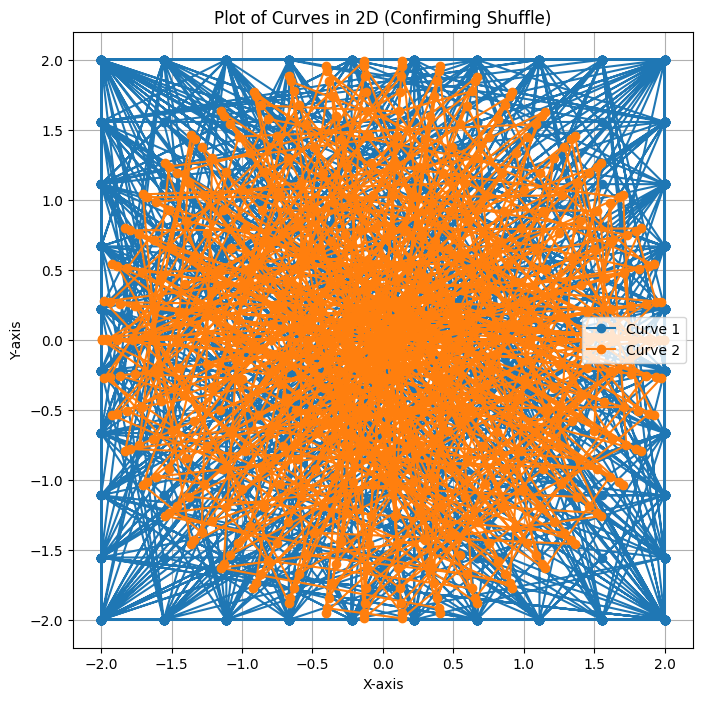

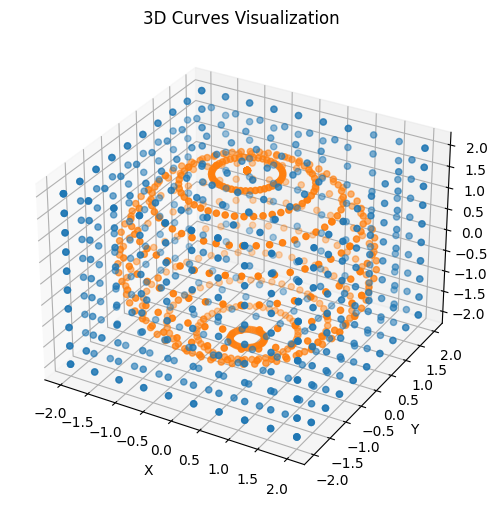

In [58]:
if output_dim == 2:
    num_curves = data.shape[0]
    plt.figure(figsize=(8, 8))
    
    for i in range(num_curves):
        curve = data[i].cpu().numpy()
        print(curve.shape)
        plt.plot(curve[:, 0], curve[:, 1], label=f'Curve {i + 1}', marker = 'o')
    
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Plot of Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
else:

    num_curves = data.shape[0]
    plt.figure(figsize=(8, 8))
    
    for i in range(num_curves):
        curve = data[i].cpu().numpy()
        print(curve.shape)
        plt.plot(curve[:, 0], curve[:, 1], label=f'Curve {i + 1}', marker = 'o')
    
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Plot of Curves in 2D (Confirming Shuffle)')
    plt.legend()
    plt.grid(True)
    plt.show()

    data_cpu = data.detach().cpu().numpy()

    # Create a 3D subplot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot each of the 20 curves
    for i in range(data_cpu.shape[0]):
        x_p = data_cpu[i, :, 0]
        y_p = data_cpu[i, :, 1]
        z_p = data_cpu[i, :, 2]
        ax.scatter(x_p, y_p, z_p, marker='o')  # marker='o' to emphasize points
    
    # Add labels and show
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('3D Curves Visualization')
    plt.show()

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_generated_curves_grid(
    model, z_in, num_samps, data, generated_disp, param_name, epoch, 
    n_rows=10, n_cols=4, xlim=(-7, 7), ylim=(-7, 7), 
    figsize=(20, 50), save_dir='notebook_plots'
):
    """
    Plots a grid of generated curves alongside reference points.

    Args:
        num_samps (int): Number of samples/generated curves to plot.
        data (torch.Tensor or np.ndarray): Reference points data (shape: [num_points, 2]).
        generated_disp (np.ndarray): Generated curves data (shape: [num_samps, num_points, 2]).
        param_name (str): Name of the parameter or folder to save the plot.
        n_rows (int): Number of rows in the grid.
        n_cols (int): Number of columns in the grid.
        xlim (tuple): X-axis limits for the plots.
        ylim (tuple): Y-axis limits for the plots.
        figsize (tuple): Size of the figure.
        save_path (str): Path to save the generated plot.
    """
    H_t = model
    Zxs = torch.empty((num_samps, num_points, zdim+int(pos_enc_L*2*xdim))).to(device)
    Zs = generate_NN_latent_functions(num_samples=num_samps, xdim=z_in.shape[1], zdim=zdim, bias=1)
    for i, model in enumerate(Zs):
        model = model.to(device)
        z = model(z_in)
        Zxs[i] = z.to(device)
    generated = H_t(Zxs).to(device)



    generated_disp = generated.to(device='cpu').detach().numpy()
    points_disp = data.to(device='cpu').detach().numpy()


    # Create a figure with a specified size
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True, sharey=True)
    axes = axes.flatten()

    # Plot each generated curve
    for i in range(num_samps):
        ax = axes[i]
        
        # Set limits
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        # Plot all reference points
        for j in range(data.shape[0]):
            ax.plot(points_disp[j, :, 0], points_disp[j, :, 1], marker='o', color='orange', linestyle='-', linewidth=0.5)
        
        # Plot the generated curve
        ax.plot(generated_disp[i, :, 0], generated_disp[i, :, 1], marker='+', color='blue', linewidth=2)
        
        # Set title for each subplot
        ax.set_title(f"Gen {i+1}")
        
        # Hide axis labels for clarity
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide unused subplots
    for i in range(num_samps, n_rows * n_cols):
        fig.delaxes(axes[i])

    # Set common x and y labels
    fig.text(0.5, 0.04, 'X', ha='center', fontsize=16)
    fig.text(0.04, 0.5, 'Y', va='center', rotation='vertical', fontsize=16)

    # Adjust layout
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

    # Add a main title
    plt.suptitle('Generated Curves Grid', fontsize=20)

    save_path = f"{save_dir}/{param_name}/Generated_Curves_Grid_{epoch}.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Save the figure
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()


# Example usage:
# Assuming `num_samps`, `data`, `generated_disp`, and `param_name` are defined
# plot_generated_curves_grid(num_samps, data, generated_disp, param_name)

In [ ]:
id += 1
param_name = str(id)

# Initialize the model and optimizer
#H_t = H_theta_new(input_dim=zdim+12, output_dim=output_dim, num_layers = 4, num_layers_inject = 3, num_neuron_inject = 1000, num_neurons = 2000).to(device)
H_t = H_theta(input_dim=zdim+int(pos_enc_L*2*xdim), output_dim=output_dim, num_layers = 4, num_neurons = 2000).to(device)
#H_t = H_theta_skip(input_dim=zdim+int(pos_enc_L*2), output_dim=output_dim)
#optimizer = optim.Adam(H_t.parameters(), lr=lr, eps=5e-1)
print(H_t)
optimizer = optim.AdamW(H_t.parameters(), lr=lr, betas=(b1, b2), eps = 1e-8)
#optimizer = optim.SGD(H_t.parameters(), lr=lr, momentum=0.9, nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=gamma, step_size= step)

os.makedirs('notebook_plots/'+param_name, exist_ok=True)

# Initialize lists to store gradient and parameter norms
grad_norms = []
param_norms = []
losses = []
Zxs = torch.empty((num_Z_samples, num_points, zdim+int(pos_enc_L*2*xdim))).to(device)
z_in = pos_encoder(x, L=pos_enc_L)

#Delta init

for e in tqdm(range(epochs)):
    # Check if we need to update the stored model parameters
    if e % staleness == 0:
        Zs = generate_NN_latent_functions(num_samples=num_Z_samples, xdim=z_in.shape[1], zdim=zdim, bias=1)
        for i, model in enumerate(Zs):
            model = model.to(device)
            z = model(z_in)
            Zxs[i] = z.to(device)
        generated = H_t(Zxs).to(device)

        #BEST THRESH = 0.45
        imle_nns = [find_nns(d, generated,  disp=False, threshold=0.0) for d in data]
        #print(imle_nns[1])
        imle_transformed_points = torch.empty((data.shape[0], num_points, zdim+int(pos_enc_L*2*xdim))).to(device)

        perturbed_Zs = []
        for i, (idx,_) in enumerate(imle_nns):
            model = Zs[idx]
            perturbed_model = copy.deepcopy(model)
            with torch.no_grad():
                for param in perturbed_model.parameters():
                    param.add_(torch.randn_like(param) * perturb_scale)
            perturbed_Zs.append(perturbed_model)
            perturbed_model = perturbed_model.to(device)
            z = perturbed_model(z_in)
            imle_transformed_points[i] = z.to(device)


    # Zero gradients, calculate loss, backpropagate, and update weights
    optimizer.zero_grad()
    outs = H_t(imle_transformed_points)
    loss = f_loss(data, outs)
    losses.append(loss.item())

    # Visualize generated points and save plots
    #if e < 900 and e >= 800:
    if e%plot_epoch == 0 or e == epochs - 1:
        generated_disp = generated.to(device='cpu').detach().numpy()
        outs_disp = outs.to(device='cpu').detach().numpy()
        points_disp = data.to(device='cpu').detach().numpy()
        plt.figure(figsize=(15, 15))
        for i in range(data.shape[0]):
            line1 = plt.plot(outs_disp[i, :, 0], outs_disp[i, :, 1], marker='+')
            color = line1[0].get_color()
            plt.plot(points_disp[i, :, 0], points_disp[i, :, 1], marker='o', color=color, linewidth=0.8, alpha=0.8)
            #plt.plot(generated_disp[:, :, 0], generated_disp[:, :, 1], marker='x', color='green')

        plot_generated_curves_grid(
            model=H_t,
            z_in=z_in,
            num_samps=40,
            data=data,  # Reference points (torch.Tensor or np.ndarray)
            generated_disp=generated_disp,  # Generated curves (np.ndarray)
            param_name=param_name,  # Folder name for saving
            epoch=e,
            n_rows=10,
            n_cols=4,
            xlim=(-2.5, 2.5),
            ylim=(-2.5, 2.5),
            figsize=(20, 50)
        )

        #print(f'Epoch {str(e)}/{epochs}', str(loss.item()))

        #plt.show()
        #Save the figutes
        
        plt.title(f'Epoch: {e}')
        plt.savefig(f"notebook_plots/{param_name}/epoch_{e}.png")
        #Close plts
        plt.close()
        # print(loss)
        # plt.figure(figsize=(15, 5))
        # plt.plot(losses, label='Loss')
        # plt.ylim(0, 15)
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.title('Loss Curve')
        # plt.legend()
        # plt.show()



    loss.backward()

    grad_sum = 0
    param_sum = 0
    for param in H_t.parameters():
        param_sum += torch.norm(param)**2
        grad_sum += torch.norm(param.grad)**2



    grad_norm = torch.sqrt(grad_sum).item()
    param_norm = torch.sqrt(param_sum).item()
    grad_norms.append(grad_norm)
    param_norms.append(param_norm)

    # print("Gradient Norm:", grad_norm)
    # print("Parameter Norm:", param_norm)

    optimizer.step()

plt.figure(figsize=(15, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig(f'notebook_plots/{param_name}/Loss Curve.png')
#plt.xticks(np.arange(0, 75), 1)
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.ylim(0, 15)
plt.savefig(f'notebook_plots/{param_name}/Loss Curve.png')
#plt.xticks(np.arange(0, 75), 1)
plt.show()

H_theta(
  (model): Sequential(
    (0): Linear(in_features=84, out_features=2000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2000, out_features=2000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2000, out_features=2000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2000, out_features=2000, bias=True)
    (7): ReLU()
    (8): Linear(in_features=2000, out_features=3, bias=True)
  )
)


 95%|██████████████████████████████████████████████████████████▉   | 14245/15000 [22:32<01:01, 12.25it/s]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Suppose 'losses' is your list/array of raw loss values
losses_arr = np.array(losses)

# Convert to a pandas Series
losses_series = pd.Series(losses_arr)

# Apply a rolling window of, say, 20 epochs (tweak this for your data)
window_size = 200
smoothed_losses = losses_series.rolling(window=window_size, center=False).mean()

# Calculate the average loss over the last 1000 epochs
last_1000_avg = np.mean(losses_arr[-1000:])

# Plot both the original and smoothed curves
plt.figure(figsize=(20, 4))
plt.plot(losses_arr, alpha=0.3, label='Raw Loss')
plt.plot(smoothed_losses, 'r-', linewidth=2, label='Smoothed Loss')

# Add a horizontal line for the average over the last 1000 epochs
plt.axhline(y=last_1000_avg, color='g', linestyle='--', label=f'Avg over last 1000 epochs ({last_1000_avg:.4f})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title(f'Loss Curve (Rolling Mean over {window_size} epochs)')
plt.legend()
plt.show()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming the following variables are already defined:
# num_samps, data, generated_disp, points_disp, param_name, device, z_in, zdim, num_points

# Generate latent functions and compute Zxs
num_samps = 15
Zxs = torch.empty((num_samps, num_points, zdim + int(pos_enc_L*2*xdim))).to(device)
Zs = generate_NN_latent_functions(num_samples=num_samps, xdim=z_in.shape[1], zdim=zdim, bias=1)

for i, model in enumerate(Zs):
    model = model.to(device)
    z = model(z_in)
    Zxs[i] = z.to(device)

# Apply transformation H_t to Zxs
generated = H_t(Zxs).to(device)

# Move generated data and input data to CPU for visualization
generated_disp = generated.to(device='cpu').detach().numpy()
points_disp = data.to(device='cpu').detach().numpy()

# Create a single figure for all generated curves
plt.figure(figsize=(10, 10))

# Set plot limits
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)



# Plot all generated curves
for i in range(num_samps):
    plt.scatter(generated_disp[i, :, 0], generated_disp[i, :, 1], marker='+', alpha=0.5, label='Generated Curves' if i == 0 else "")
    # Plot all reference points
    for j in range(data.shape[0]):
        plt.scatter(points_disp[j, :, 0], points_disp[j, :, 1], marker='o', color='orange', alpha=0.5, label='Reference Points' if j == 0 else "")

    # Add title and labels
plt.title('All Generated Curves', fontsize=20)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)

# Add a legend to distinguish reference points and generated curves
#plt.legend()

# Save the plot as a single image
plt.savefig(f'notebook_plots/{param_name}/All_Generated_Curves.png', bbox_inches='tight')

# Display the plot
plt.show()



In [ ]:
import os
num_samps = 15
Zxs = torch.empty((num_samps, num_points, zdim + int(pos_enc_L*2*xdim))).to(device)
Zs = generate_NN_latent_functions(num_samples=num_samps, xdim=z_in.shape[1], zdim=zdim, bias=1)
# Create a directory to store the .obj files
output_dir = "generated_objs"
os.makedirs(output_dir, exist_ok=True)

for i, model in enumerate(Zs):
    model = model.to(device)
    z = model(z_in)
    Zxs[i] = z.to(device)
    generated = H_t(Zxs[i]).to(device)  # Shape: (576, 3)

    # Extract the generated points as a numpy array
    points = generated.detach().cpu().numpy()

    # Define the filename for the .obj file
    obj_filename = os.path.join(output_dir, f"generated_points_{i}.obj")

    # Write the points to the .obj file
    with open(obj_filename, "w") as f:
        for point in points:
            f.write(f"v {point[0]} {point[1]} {point[2]}\n")
    
    print(f"Saved {obj_filename}")

In [ ]:
num_samps = 15
Zxs = torch.empty((num_samps, num_points, zdim + int(pos_enc_L*2*xdim))).to(device)
Zs = generate_NN_latent_functions(num_samples=num_samps, xdim=z_in.shape[1], zdim=zdim, bias=1)

# Define figure with 15 rows and 3 columns
fig, axs = plt.subplots(num_samps, 3, figsize=(18, 6 * num_samps), subplot_kw={'projection': '3d'})

for i, model in enumerate(Zs):
    model = model.to(device)
    z = model(z_in)
    Zxs[i] = z.to(device)

    generated = H_t(Zxs[i]).to(device) #576x3
    
    generated_disp = generated.cpu().detach().numpy()
    points_disp = data.cpu().detach().numpy()

    # Extract coordinates for generated and real data
    xg, yg, zg = generated_disp[:, 0], generated_disp[:, 1], generated_disp[:, 2]
    x_real, y_real, z_real = points_disp[:, :, 0], points_disp[:, :, 1], points_disp[:, :, 2]

    # First view
    axs[i, 0].scatter(xg, yg, zg, marker='o', label='Generated')
    axs[i, 0].scatter(x_real, y_real, z_real, marker='x', alpha=0.5, label='Real data')
    axs[i, 0].set_title(f'Sample {i + 1} - View 1')
    axs[i, 0].view_init(elev=20, azim=30)

    # Second view
    axs[i, 1].scatter(xg, yg, zg, marker='o', label='Generated')
    axs[i, 1].scatter(x_real, y_real, z_real, marker='x', alpha=0.5, label='Real data')
    axs[i, 1].set_title(f'Sample {i + 1} - View 2')
    axs[i, 1].view_init(elev=40, azim=-60)

    # Third view
    axs[i, 2].scatter(xg, yg, zg, marker='o', label='Generated')
    axs[i, 2].scatter(x_real, y_real, z_real, marker='x', alpha=0.5, label='Real data')
    axs[i, 2].set_title(f'Sample {i + 1} - View 3')
    axs[i, 2].view_init(elev=60, azim=120)

# Set labels
for ax_row in axs:
    for ax in ax_row:
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
plt.tight_layout()
plt.savefig(f"notebook_plots/{param_name}/generated_samples.png", dpi=300, bbox_inches="tight")
plt.show()
